In [1]:
from sae_lens import HookedSAETransformer
import torch
from torch.nn.functional import cosine_similarity
import matplotlib.pyplot as plt
import datasets
from collections import defaultdict
import time
import os
import json

In [2]:
def get_texts(n_texts):
    data = datasets.load_dataset('NeelNanda/pile-10k')['train']
    texts = []

    for i, t in enumerate(data):
        if len(t['text']) > 6000:
            texts.append(t['text'])

        if len(texts) == n_texts:
            break
    
    if len(texts) < n_texts:
        raise ValueError('not enough texts, only found', len(texts))


    print('went through', i, 'texts')

    return texts


In [6]:
transformer_name = 'gemma-2b'
device = 'cuda'
layer = 14
hook_name = 'blocks.13.hook_resid_pre'
max_length = 1024

In [4]:
transformer = HookedSAETransformer.from_pretrained(transformer_name, device=device)
transformer.eval()
tok = transformer.tokenizer


`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model gemma-2b into HookedTransformer


TypeError: get_texts() takes 1 positional argument but 2 were given

In [53]:
sequence = 'I like apples every day'
tokens = tok(sequence, return_tensors='pt', padding=True, truncation=True, max_length=max_length).input_ids
tok_strs = tok.convert_ids_to_tokens(tokens[0])

In [54]:
_, activations = transformer.run_with_cache(tokens, prepend_bos=False, stop_at_layer=layer)
activations = activations[hook_name].squeeze()

In [76]:
sequence = 'apples'
tokens = tok(sequence, return_tensors='pt', padding=True, truncation=True, max_length=max_length).input_ids
tokens
_, apple_act = transformer.run_with_cache(tokens, prepend_bos=False, stop_at_layer=layer)
apple_act = apple_act[hook_name].squeeze()[-1]

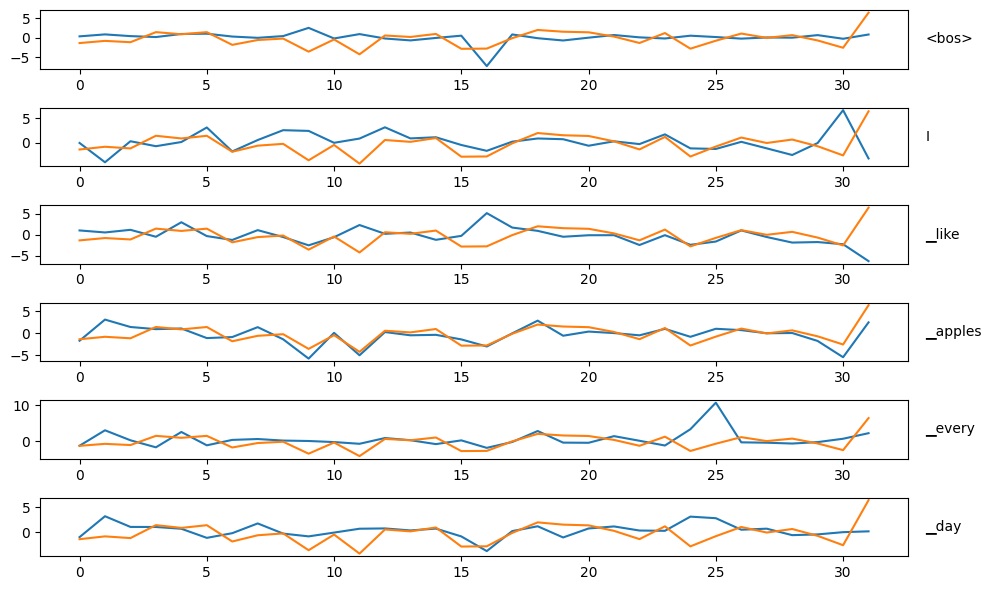

In [57]:
f, ax = plt.subplots(activations.shape[0], 1, figsize=(10, 6))

for i in range(activations.shape[0]):
    ax[i].plot(activations[i][:32].cpu())
    ax[i].plot(every[:32].cpu())

    label_x = 1.02  # x position relative to the axes (1 = right edge)
    label_y = 0.5  # y position relative to the axes (0.5 = center)
    ax[i].text(label_x, label_y, tok_strs[i], horizontalalignment='left', verticalalignment='center', transform=ax[i].transAxes)

plt.tight_layout()

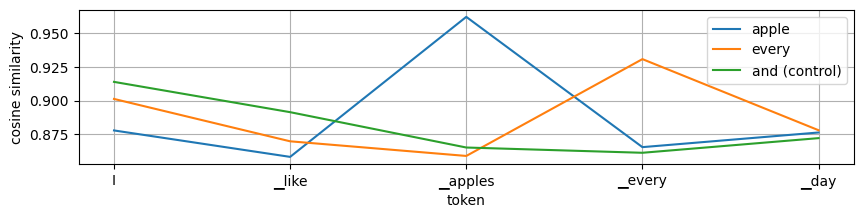

In [86]:

cos = defaultdict(list)

for i in range(activations.shape[0]):
    cos['apple'].append(cosine_similarity(activations[i].unsqueeze(0), apple_act.unsqueeze(0)).item())
    cos['every'].append(cosine_similarity(activations[i].unsqueeze(0), every.unsqueeze(0)).item())
    cos['and (control)'].append(cosine_similarity(activations[i].unsqueeze(0), and_act.unsqueeze(0)).item())

plt.figure(figsize=(10, 2))

for k, v in cos.items():
    plt.plot(tok_strs[1:], v[1:], label=k)

plt.xlabel('token')
plt.ylabel('cosine similarity')
plt.legend()
plt.grid()


In [65]:
acts = show_acts('gemma-2-9b', 33, 'blocks.32.hook_resid_pre', 'cuda', 10, 2)
acts = torch.stack(acts)
a = torch.mean(acts, dim=0)

plt.figure(figsize=(20, 10))
for i in range(2048):
    plt.plot(a[:10, i], alpha=0.05)

plt.ylim(-15, 15)
plt.grid()


NameError: name 'show_acts' is not defined

In [ ]:
texts = get_texts(100)
# input = tok(texts, padding=True, truncation=True, return_tensors='pt', max_length=max_length)